In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/63.1 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.1 MB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.6 MB/s eta 0:00:00


In [2]:

#create samples :
import os
import torch
import pickle
import pandas as pd

def load_graph(path, is_pickle=True):
    """
    Load a molecule graph (.pkl) or a protein graph (.pt).
    If is_pickle is True, use pickle to load the file; otherwise, use torch.load.
    """
    if is_pickle:
        with open(path, 'rb') as f:
            return pickle.load(f)
    else:
        return torch.load(path)

def prepare_dataset_individual_save_as_pt(filtered_dataset, molecule_graph_dir, protein_graph_dir, output_dir):
    """
    Incrementally prepares the dataset and saves each (molecule, protein, target) tuple as a separate .pt file.

    Args:
    - filtered_dataset: The filtered KIBA dataset (DataFrame).
    - molecule_graph_dir: Directory where molecule graphs are stored.
    - protein_graph_dir: Directory where protein graphs are stored.
    - output_dir: Directory to save the prepared dataset incrementally.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for index, row in filtered_dataset.iterrows():
        protein_id = row['Target_ID']
        chembl_id = row['Drug_ID']

        # Load the protein graph (.pt)
        pro_graph_path = os.path.join(protein_graph_dir, f"{protein_id}_graph.pt")
        if not os.path.exists(pro_graph_path):
            print(f"Protein graph not found: {protein_id}")
            continue
        pro_graph = load_graph(pro_graph_path, is_pickle=False)

        # Load the molecule graph (.pkl)
        mol_graph_path = os.path.join(molecule_graph_dir, f"{chembl_id}_graph.pkl")
        if not os.path.exists(mol_graph_path):
            print(f"Molecule graph not found: {chembl_id}")
            continue
        mol_graph = load_graph(mol_graph_path)

        # Load target (affinity value)
        target = torch.tensor([row['Y']], dtype=torch.float)

        # Create the sample as a tuple (molecule graph, protein graph, target)
        sample = (mol_graph, pro_graph, target)

        # Save the sample as a .pt file
        sample_path = os.path.join(output_dir, f"sample_{index}.pt")
        torch.save(sample, sample_path)

        if(index%10000 == 0 ):
            print(f"Saved sample {index} as {sample_path}")




# Example usage for individual saving
molecule_graph_dir = '//kaggle/input/davis-graphs/molecule_graphs'  # Directory where molecule graphs are stored
protein_graph_dir = '/kaggle/input/davis-graphs/ProteinGraphs'  # Directory where protein graphs are stored
filtered_dataset_path = '/kaggle/input/davis-graphs/filtered_DavisDataSet.csv'  # Path to the filtered dataset CSV
output_dir = 'prepared_samples/'  # Directory to save individual samples

# Load filtered dataset CSV
filtered_dataset = pd.read_csv(filtered_dataset_path)

# Prepare the dataset incrementally, saving each sample as a .pt file
prepare_dataset_individual_save_as_pt(filtered_dataset, molecule_graph_dir, protein_graph_dir, output_dir)

print("Dataset preparation completed.")



<ipython-input-2-bb0f95ffdbd8>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)


Saved sample 0 as prepared_samples/sample_0.pt


<ipython-input-2-bb0f95ffdbd8>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)


Saved sample 10000 as prepared_samples/sample_10000.pt


Dataset preparation completed.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
class NonLocalBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=None, chunk_size=2048):
        super().__init__()
        self.output_dim = output_dim or input_dim

        # GCN-based projections (Φ, Θ, Γ)
        # Φ: H = σ(Â H W_φ + b_φ), where Â = D^{-1/2} (A + I) D^{-1/2}
        self.W_phi = GCNConv(input_dim, hidden_dim)
        self.W_theta = GCNConv(input_dim, hidden_dim)
        self.W_gamma = GCNConv(input_dim, hidden_dim)

        # Output projection: O = O_{agg} W_{out} + b_{out}
        self.W_out = nn.Linear(hidden_dim, self.output_dim)

        # Residual connection: V_n = O + V_m (if dimensions match)
        self.res_proj = nn.Linear(input_dim, self.output_dim) if input_dim != self.output_dim else nn.Identity()

        self.chunk_size = chunk_size

    def forward(self, V_m, edge_index):
        # Step 1: Compute Φ, Θ, Γ using GCNConv
        # Φ = GCN(V_m, edge_index), Θ = GCN(V_m, edge_index), Γ = GCN(V_m, edge_index)
        phi = self.W_phi(V_m, edge_index)  # Φ ∈ ℝ^{N×h}
        theta = self.W_theta(V_m, edge_index)  # Θ ∈ ℝ^{N×h}
        gamma = self.W_gamma(V_m, edge_index)  # Γ ∈ ℝ^{N×h}

        N = phi.size(0)
        O = torch.zeros_like(gamma)

        # Step 2: Chunked attention computation
        for i in range(0, N, self.chunk_size):
            # For chunk i: Φ_chunk = Φ[i:i+chunk_size]
            phi_chunk = phi[i:i + self.chunk_size]  # Φ_chunk ∈ ℝ^{C×h}

            # Compute similarity scores: S = (Θ Φ_chunk^T) / √h
            sim_chunk = torch.einsum('nh,ch->cn', theta, phi_chunk)  # S ∈ ℝ^{C×N}
            sim_chunk = sim_chunk / (phi.size(1) ** 0.5)  # Scaling by √h

            # Softmax normalization: α = softmax(S, dim=1)
            attn_chunk = F.softmax(sim_chunk, dim=1)  # α ∈ ℝ^{C×N}

            # Aggregate values: O_chunk = α Γ
            O_chunk = torch.einsum('cn,nh->ch', attn_chunk, gamma)  # O_chunk ∈ ℝ^{C×h}
            O[i:i + self.chunk_size] = O_chunk

            del phi_chunk, sim_chunk, attn_chunk, O_chunk
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # Step 3: Projection and residual connection
        O_projected = self.W_out(O)  # O_projected ∈ ℝ^{N×d_out}
        V_n = O_projected + self.res_proj(V_m)  # V_n = O_projected + V_m (with dim alignment)
        return V_n

In [4]:
# !rm -rf "TrainingModelNLB"

In [5]:
import os
training_model_dir = os.path.join(os.getcwd(), 'TrainingModelNLB')
os.makedirs(training_model_dir, exist_ok=True)

In [6]:
!cp '/kaggle/input/ep180/pytorch/default/1/model_epoch180.pt'  'TrainingModelNLB/model_epoch180.pt'
!cp '/kaggle/input/ep180/pytorch/default/1/training_metrics.pt'  'TrainingModelNLB/training_metrics.pt'

In [7]:
#model one
import os
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import MSELoss
from torch_geometric.nn import GCNConv, global_mean_pool as gep
from torch_geometric.data import Data, Batch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

# Optional, for plotting:
import matplotlib.pyplot as plt

##############################################################################
#                               1. METRICS
##############################################################################

@torch.no_grad()
def ci_vectorized(preds: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Naive O(N^2) Concordance Index using vectorized GPU operations.
    preds, targets: (N,) on the same device (e.g. cuda).
    """
    # (N, N) differences
    p_diff = preds.unsqueeze(1) - preds.unsqueeze(0)
    t_diff = targets.unsqueeze(1) - targets.unsqueeze(0)
    # mask out pairs where targets are identical
    mask = (t_diff != 0)
    # sign of product => +1 (concordant), 0 (tie), -1 (discordant)
    sign_mat = torch.sign(p_diff * t_diff)
    # step function h(x): 1 if x>0, 0.5 if x=0, 0 if x<0
    h = (sign_mat == 1).float() + 0.5 * (sign_mat == 0).float()
    # apply mask
    h_masked = h * mask.float()
    c = h_masked.sum()
    s = mask.sum().float()
    return (c / s).item() if s > 0 else 0.0

@torch.no_grad()
def mse_torch(preds: torch.Tensor, targets: torch.Tensor) -> float:
    """
    GPU-friendly MSE using torch's built-in mean squared error.
    """
    return F.mse_loss(preds, targets, reduction='mean').item()

@torch.no_grad()
def pearson_torch(preds: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Pearson correlation coefficient in PyTorch (GPU-friendly).
    preds, targets: (N,) on the same device
    """
    p_centered = preds - preds.mean()
    t_centered = targets - targets.mean()
    cov = (p_centered * t_centered).sum()
    denom = torch.sqrt((p_centered**2).sum()) * torch.sqrt((t_centered**2).sum())
    eps = 1e-8
    return (cov / (denom + eps)).item()

##############################################################################
#                       2. GNN MODEL DEFINITION
##############################################################################

class GNNNet(torch.nn.Module):
    def __init__(self, n_output=1, num_features_pro=54, num_features_mol=78, output_dim=128, hidden_dim=128, dropout=0.2):
        super(GNNNet, self).__init__()

        print('GNNNet Loaded')
        self.n_output = n_output
        self.hidden_dim = hidden_dim

        # Molecular graph pipeline
        self.mol_conv1 = GCNConv(num_features_mol, num_features_mol)
        self.mol_nonlocal = NonLocalBlock(num_features_mol, hidden_dim, num_features_mol * 2)
        self.mol_conv3 = GCNConv(num_features_mol * 2, num_features_mol * 4)
        self.mol_fc_g1 = torch.nn.Linear(num_features_mol * 4, 1024)
        self.mol_fc_g2 = torch.nn.Linear(1024, output_dim)

        # Protein graph pipeline
        self.pro_conv1 = GCNConv(num_features_pro, num_features_pro)
        self.pro_nonlocal = NonLocalBlock(num_features_pro, hidden_dim, num_features_pro * 2)
        self.pro_conv3 = GCNConv(num_features_pro * 2, num_features_pro * 4)
        self.pro_fc_g1 = torch.nn.Linear(num_features_pro * 4, 1024)
        self.pro_fc_g2 = torch.nn.Linear(1024, output_dim)

        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout)

        # Combined layers
        self.fc1 = torch.nn.Linear(2 * output_dim, 1024)
        self.fc2 = torch.nn.Linear(1024, 512)
        self.out = torch.nn.Linear(512, self.n_output)

    def forward(self, data_mol, data_pro):
        # Molecular graph input
        mol_x, mol_edge_index, mol_batch = data_mol.x, data_mol.edge_index, data_mol.batch
        mol_x = self.mol_conv1(mol_x, mol_edge_index)
        mol_x = self.relu(mol_x)
        mol_x = self.mol_nonlocal(mol_x ,mol_edge_index)  # Non-local block
        mol_x = self.mol_conv3(mol_x, mol_edge_index)
        mol_x = self.relu(mol_x)
        mol_x = gep(mol_x, mol_batch)  # Global pooling
        mol_x = self.relu(self.mol_fc_g1(mol_x))
        mol_x = self.dropout(mol_x)
        mol_x = self.mol_fc_g2(mol_x)
        mol_x = self.dropout(mol_x)

        # Protein graph input
        pro_x, pro_edge_index, pro_batch = data_pro.x, data_pro.edge_index, data_pro.batch
        pro_x = self.pro_conv1(pro_x, pro_edge_index)
        pro_x = self.relu(pro_x)
        pro_x = self.pro_nonlocal(pro_x,pro_edge_index)  # Non-local block
        pro_x = self.pro_conv3(pro_x, pro_edge_index)
        pro_x = self.relu(pro_x)
        pro_x = gep(pro_x, pro_batch)  # Global pooling
        pro_x = self.relu(self.pro_fc_g1(pro_x))
        pro_x = self.dropout(pro_x)
        pro_x = self.pro_fc_g2(pro_x)
        pro_x = self.dropout(pro_x)

        # Concatenate molecular and protein features
        xc = torch.cat((mol_x, pro_x), dim=1)
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out



##############################################################################
#                   3. DATA LOADING HELPERS
##############################################################################

warnings.filterwarnings('ignore', category=FutureWarning)

def load_sample(path):
    """
    Load a .pt sample, fix up 'x' and 'edge_index', return (mol_data, pro_data, target).
    """
    sample = torch.load(path)
    mol_data, pro_data, target = sample[0], sample[1], sample[2]

    # Convert dict to Data if needed
    if isinstance(mol_data, dict):
        mol_data = Data(**mol_data)
    if isinstance(pro_data, dict):
        pro_data = Data(**pro_data)

    # Fix x
    if not hasattr(mol_data, 'x') or mol_data.x is None:
        if hasattr(mol_data, 'features'):
            mol_data.x = mol_data.features
            del mol_data.features
        else:
            raise ValueError("mol_data missing 'x' or 'features'")
    if not hasattr(pro_data, 'x') or pro_data.x is None:
        if hasattr(pro_data, 'features'):
            pro_data.x = pro_data.features
            del pro_data.features
        else:
            raise ValueError("pro_data missing 'x' or 'features'")

    mol_data.x = torch.as_tensor(mol_data.x, dtype=torch.float32)
    pro_data.x = torch.as_tensor(pro_data.x, dtype=torch.float32)

    # Fix edge_index
    def fix_edge_index(d):
        if not isinstance(d.edge_index, torch.Tensor):
            d.edge_index = torch.tensor(d.edge_index, dtype=torch.long)
        else:
            d.edge_index = d.edge_index.long()
        if d.edge_index.shape[0] != 2:
            d.edge_index = d.edge_index.t()
        d.num_nodes = d.x.size(0)

    fix_edge_index(mol_data)
    fix_edge_index(pro_data)

    return (mol_data, pro_data, target)

def batch_loader(file_list, sample_dir, batch_size):
    """
    Yields batches of (mol_data, pro_data, target) from file_list.
    """
    batch = []
    for file_name in file_list:
        path = os.path.join(sample_dir, file_name)
        sample = load_sample(path)
        batch.append(sample)
        if len(batch) == batch_size:
            yield batch
            batch = []
    if batch:
        yield batch

##############################################################################
#              4. TRAINING / EVALUATION WITH METRICS EACH EPOCH
##############################################################################
import os
import torch

def train_and_evaluate(sample_dir, num_epochs=10, test_size=0.2, lr=0.001):
    """
    Trains the GNN model, evaluates on train & test each epoch, saves metrics + checkpoints.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running on {device}.")

    # Gather samples
    sample_files = [f for f in os.listdir(sample_dir) if f.endswith('.pt')]
    assert len(sample_files) > 0, "No .pt files found in sample_dir!"

    # Split
    train_files, test_files = train_test_split(sample_files, test_size=test_size, random_state=42)

    # Make checkpoint dir
    training_model_dir = os.path.join(os.getcwd(), 'TrainingModelNLB')
    os.makedirs(training_model_dir, exist_ok=True)
    print(f"Checkpoints will be saved to: {training_model_dir}")

    metrics_path = os.path.join(training_model_dir, "training_metrics.pt")

    # Load existing metrics if available (Ensures metrics continue from previous runs)
    if os.path.exists(metrics_path):
        saved_metrics = torch.load(metrics_path)
        train_metrics = saved_metrics['train_metrics']
        test_metrics = saved_metrics['test_metrics']
        print("Loaded previous training metrics!")
    else:
        train_metrics = {'epoch': [], 'mse': [], 'ci': [], 'pearson': []}
        test_metrics = {'epoch': [], 'mse': [], 'ci': [], 'pearson': []}
        print("Starting fresh metrics tracking.")

    # Infer input dims from one sample
    sample0 = load_sample(os.path.join(sample_dir, train_files[0]))
    mol_data0, pro_data0 = sample0[0], sample0[1]
    num_features_mol = mol_data0.x.size(1)
    num_features_pro = pro_data0.x.size(1)

    # Initialize model
    model = GNNNet(num_features_mol=num_features_mol,
                   num_features_pro=num_features_pro).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = MSELoss()

    # Possibly resume from checkpoint
    start_epoch = 1
    existing_checkpoints = [
        f for f in os.listdir(training_model_dir)
        if f.endswith('.pt') and f.startswith('model_epoch')
    ]
    last_ckpt_path = None  # Track previous checkpoint for deletion

    if existing_checkpoints:
        latest_ckpt = max(existing_checkpoints, key=lambda x: int(x.split('_epoch')[1].split('.pt')[0]))
        ckpt_path = os.path.join(training_model_dir, latest_ckpt)
        print(f"Loading checkpoint from {ckpt_path}")
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        loaded_epoch = ckpt['epoch']
        start_epoch = loaded_epoch + 1
        last_ckpt_path = ckpt_path  # Store last checkpoint path for deletion
        print(f"Resuming from epoch {start_epoch}")
    else:
        print("No existing checkpoint found; starting fresh.")

    @torch.no_grad()
    def evaluate(files):
        model.eval()
        all_preds = []
        all_targets = []
        batch_eval_size = 200
        for batch_samples in batch_loader(files, sample_dir, batch_eval_size):
            mol_list, pro_list, tgt_list = [], [], []
            for (md, pd, t) in batch_samples:
                mol_list.append(md)
                pro_list.append(pd)
                tgt_list.append(t)

            mol_batch = Batch.from_data_list(mol_list).to(device)
            pro_batch = Batch.from_data_list(pro_list).to(device)
            t_tensor = torch.tensor(tgt_list, dtype=torch.float32, device=device)

            out = model(mol_batch, pro_batch).view(-1)
            all_preds.append(out)
            all_targets.append(t_tensor)

        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        mse_val = mse_torch(all_preds, all_targets)
        ci_val = ci_vectorized(all_preds, all_targets)
        pearson_val = pearson_torch(all_preds, all_targets)
        return mse_val, ci_val, pearson_val

    # Training loop
    batch_size = 61
    for epoch in tqdm(range(start_epoch, num_epochs + 1), desc="Training", unit="epoch"):
        model.train()
        running_loss = 0.0

        for batch_samples in batch_loader(train_files, sample_dir, batch_size):
            mol_list, pro_list, tgt_list = [], [], []
            for (md, pd, t) in batch_samples:
                mol_list.append(md)
                pro_list.append(pd)
                tgt_list.append(t)

            mol_batch = Batch.from_data_list(mol_list).to(device)
            pro_batch = Batch.from_data_list(pro_list).to(device)
            t_tensor = torch.tensor(tgt_list, dtype=torch.float32, device=device).view(-1)

            optimizer.zero_grad()
            out = model(mol_batch, pro_batch).view(-1)
            loss = loss_fn(out, t_tensor)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(batch_samples)

        avg_loss = running_loss / len(train_files)
        tqdm.write(f"[Epoch {epoch}/{num_epochs}] Training Loss: {avg_loss:.4f}")

        # Evaluate on train & test
        train_mse, train_ci, train_pearson = evaluate(train_files)
        test_mse, test_ci, test_pearson = evaluate(test_files)

        train_metrics['epoch'].append(epoch)
        train_metrics['mse'].append(train_mse)
        train_metrics['ci'].append(train_ci)
        train_metrics['pearson'].append(train_pearson)

        test_metrics['epoch'].append(epoch)
        test_metrics['mse'].append(test_mse)
        test_metrics['ci'].append(test_ci)
        test_metrics['pearson'].append(test_pearson)

        tqdm.write(f"  Train => MSE={train_mse:.4f}, CI={train_ci:.4f}, Pearson={train_pearson:.4f}")
        tqdm.write(f"  Test  => MSE={test_mse:.4f}, CI={test_ci:.4f}, Pearson={test_pearson:.4f}")

        # Save new checkpoint
        ckpt_name = f"model_epoch{epoch}.pt"
        ckpt_path = os.path.join(training_model_dir, ckpt_name)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, ckpt_path)
        tqdm.write(f"Checkpoint saved at epoch {epoch}")

        # Delete the previous checkpoint after saving the new one
        if last_ckpt_path and os.path.exists(last_ckpt_path):
            os.remove(last_ckpt_path)
            tqdm.write(f"Deleted previous checkpoint: {last_ckpt_path}")

        # Update last checkpoint path
        last_ckpt_path = ckpt_path

        # Save/Update the metrics after each epoch
        torch.save({
            'train_metrics': train_metrics,
            'test_metrics': test_metrics
        }, metrics_path)

    # Final evaluations
    final_train_mse, final_train_ci, final_train_pearson = evaluate(train_files)
    final_test_mse, final_test_ci, final_test_pearson = evaluate(test_files)
    print(f"\nFinal Train => MSE={final_train_mse:.4f}, CI={final_train_ci:.4f}, Pearson={final_train_pearson:.4f}")
    print(f"Final Test  => MSE={final_test_mse:.4f}, CI={final_test_ci:.4f}, Pearson={final_test_pearson:.4f}")

    # Save final metrics
    torch.save({
        'train_metrics': train_metrics,
        'test_metrics': test_metrics
    }, metrics_path)
    print(f"Metrics saved to {metrics_path}")

    return train_metrics, test_metrics


##############################################################################
#               5. OPTIONAL: PLOT THE SAVED METRICS
##############################################################################

def plot_metrics(checkpoint_dir='TrainingModelNLB'):
    """
    Load training_metrics.pt from the checkpoint_dir and plot MSE, CI, Pearson over epochs.
    """
    metrics_path = os.path.join(checkpoint_dir, "training_metrics.pt")
    if not os.path.exists(metrics_path):
        print(f"No metrics file found at {metrics_path}!")
        return

    saved_data = torch.load(metrics_path)
    train_metrics = saved_data['train_metrics']
    test_metrics = saved_data['test_metrics']
    epochs = train_metrics['epoch']

    # Plot MSE
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['mse'], 'o-', label='Train MSE')
    plt.plot(epochs, test_metrics['mse'], 'o-', label='Test MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "MSE_plot.png"))  
    plt.show()

    # Plot CI
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['ci'], 'o-', label='Train CI')
    plt.plot(epochs, test_metrics['ci'], 'o-', label='Test CI')
    plt.xlabel('Epoch')
    plt.ylabel('Concordance Index')
    plt.title('CI over Epochs')
    plt.savefig(os.path.join(checkpoint_dir, "CI_plot.png"))  
    plt.legend()
    plt.show()

    # Plot Pearson
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['pearson'], 'o-', label='Train Pearson')
    plt.plot(epochs, test_metrics['pearson'], 'o-', label='Test Pearson')
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Correlation')
    plt.title('Pearson Correlation over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "PEARSON_plot.png"))  
    plt.show()

##############################################################################
#                                 MAIN
##############################################################################

if __name__ == "__main__":
    # Adjust the paths/parameters as needed
    SAMPLE_DIR = "prepared_samples"   # Directory with your .pt samples
    NUM_EPOCHS = 250
    TEST_SPLIT = 0.2
    LR = 0.001

    # 1) Train and evaluate
    train_metrics, test_metrics = train_and_evaluate(
        sample_dir=SAMPLE_DIR,
        num_epochs=NUM_EPOCHS,
        test_size=TEST_SPLIT,
        lr=LR
    )

    # 2) Plot the metrics
    plot_metrics('TrainingModelNLB')

Running on cuda.
Checkpoints will be saved to: /kaggle/working/TrainingModelNLB
Loaded previous training metrics!
GNNNet Loaded


Loading checkpoint from /kaggle/working/TrainingModelNLB/model_epoch180.pt
Resuming from epoch 181


Training:   0%|          | 0/70 [00:00<?, ?epoch/s]

Training:   0%|          | 0/70 [07:58<?, ?epoch/s]

[Epoch 181/250] Training Loss: 0.2659


Training:   0%|          | 0/70 [23:37<?, ?epoch/s]

Training:   0%|          | 0/70 [23:37<?, ?epoch/s]

Training:   0%|          | 0/70 [23:37<?, ?epoch/s]

Training:   0%|          | 0/70 [23:37<?, ?epoch/s]

Training:   1%|▏         | 1/70 [23:37<27:09:57, 1417.36s/epoch]

  Train => MSE=0.1913, CI=0.8915, Pearson=0.8716
  Test  => MSE=0.2060, CI=0.8904, Pearson=0.8599
Checkpoint saved at epoch 181
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch180.pt


Training:   1%|▏         | 1/70 [31:31<27:09:57, 1417.36s/epoch]

[Epoch 182/250] Training Loss: 0.2644


Training:   1%|▏         | 1/70 [47:09<27:09:57, 1417.36s/epoch]

Training:   1%|▏         | 1/70 [47:09<27:09:57, 1417.36s/epoch]

Training:   1%|▏         | 1/70 [47:09<27:09:57, 1417.36s/epoch]

Training:   1%|▏         | 1/70 [47:09<27:09:57, 1417.36s/epoch]

Training:   3%|▎         | 2/70 [47:09<26:43:08, 1414.53s/epoch]

  Train => MSE=0.2254, CI=0.8877, Pearson=0.8647
  Test  => MSE=0.2471, CI=0.8812, Pearson=0.8464
Checkpoint saved at epoch 182
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch181.pt


Training:   3%|▎         | 2/70 [55:03<26:43:08, 1414.53s/epoch]

[Epoch 183/250] Training Loss: 0.2540


Training:   3%|▎         | 2/70 [1:10:41<26:43:08, 1414.53s/epoch]

Training:   3%|▎         | 2/70 [1:10:41<26:43:08, 1414.53s/epoch]

Training:   3%|▎         | 2/70 [1:10:41<26:43:08, 1414.53s/epoch]

Training:   3%|▎         | 2/70 [1:10:41<26:43:08, 1414.53s/epoch]

Training:   4%|▍         | 3/70 [1:10:41<26:18:03, 1413.18s/epoch]

  Train => MSE=0.1822, CI=0.8858, Pearson=0.8736
  Test  => MSE=0.2151, CI=0.8762, Pearson=0.8492
Checkpoint saved at epoch 183
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch182.pt


Training:   4%|▍         | 3/70 [1:18:34<26:18:03, 1413.18s/epoch]

[Epoch 184/250] Training Loss: 0.2547


Training:   4%|▍         | 3/70 [1:34:12<26:18:03, 1413.18s/epoch]

Training:   4%|▍         | 3/70 [1:34:12<26:18:03, 1413.18s/epoch]

Training:   4%|▍         | 3/70 [1:34:12<26:18:03, 1413.18s/epoch]

Training:   4%|▍         | 3/70 [1:34:12<26:18:03, 1413.18s/epoch]

Training:   6%|▌         | 4/70 [1:34:12<25:53:36, 1412.37s/epoch]

  Train => MSE=0.1913, CI=0.8924, Pearson=0.8742
  Test  => MSE=0.2280, CI=0.8844, Pearson=0.8457
Checkpoint saved at epoch 184
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch183.pt


Training:   6%|▌         | 4/70 [1:42:04<25:53:36, 1412.37s/epoch]

[Epoch 185/250] Training Loss: 0.2452


Training:   6%|▌         | 4/70 [1:57:42<25:53:36, 1412.37s/epoch]

Training:   6%|▌         | 4/70 [1:57:42<25:53:36, 1412.37s/epoch]

Training:   6%|▌         | 4/70 [1:57:42<25:53:36, 1412.37s/epoch]

Training:   6%|▌         | 4/70 [1:57:42<25:53:36, 1412.37s/epoch]

Training:   7%|▋         | 5/70 [1:57:42<25:29:10, 1411.54s/epoch]

  Train => MSE=0.1864, CI=0.8879, Pearson=0.8739
  Test  => MSE=0.2200, CI=0.8820, Pearson=0.8479
Checkpoint saved at epoch 185
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch184.pt


Training:   7%|▋         | 5/70 [2:05:36<25:29:10, 1411.54s/epoch]

[Epoch 186/250] Training Loss: 0.2453


Training:   7%|▋         | 5/70 [2:21:14<25:29:10, 1411.54s/epoch]

Training:   7%|▋         | 5/70 [2:21:14<25:29:10, 1411.54s/epoch]

Training:   7%|▋         | 5/70 [2:21:14<25:29:10, 1411.54s/epoch]

Training:   7%|▋         | 5/70 [2:21:14<25:29:10, 1411.54s/epoch]

Training:   9%|▊         | 6/70 [2:21:14<25:05:48, 1411.70s/epoch]

  Train => MSE=0.1834, CI=0.8911, Pearson=0.8760
  Test  => MSE=0.2256, CI=0.8828, Pearson=0.8444
Checkpoint saved at epoch 186
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch185.pt


Training:   9%|▊         | 6/70 [2:29:08<25:05:48, 1411.70s/epoch]

[Epoch 187/250] Training Loss: 0.2456


Training:   9%|▊         | 6/70 [2:44:47<25:05:48, 1411.70s/epoch]

Training:   9%|▊         | 6/70 [2:44:47<25:05:48, 1411.70s/epoch]

Training:   9%|▊         | 6/70 [2:44:47<25:05:48, 1411.70s/epoch]

Training:   9%|▊         | 6/70 [2:44:47<25:05:48, 1411.70s/epoch]

Training:  10%|█         | 7/70 [2:44:47<24:42:35, 1411.99s/epoch]

  Train => MSE=0.1906, CI=0.8896, Pearson=0.8717
  Test  => MSE=0.2378, CI=0.8811, Pearson=0.8358
Checkpoint saved at epoch 187
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch186.pt


Training:  10%|█         | 7/70 [2:52:40<24:42:35, 1411.99s/epoch]

[Epoch 188/250] Training Loss: 0.2508


Training:  10%|█         | 7/70 [3:08:18<24:42:35, 1411.99s/epoch]

Training:  10%|█         | 7/70 [3:08:18<24:42:35, 1411.99s/epoch]

Training:  10%|█         | 7/70 [3:08:18<24:42:35, 1411.99s/epoch]

Training:  10%|█         | 7/70 [3:08:18<24:42:35, 1411.99s/epoch]

Training:  11%|█▏        | 8/70 [3:08:18<24:18:44, 1411.69s/epoch]

  Train => MSE=0.1749, CI=0.8987, Pearson=0.8812
  Test  => MSE=0.2212, CI=0.8889, Pearson=0.8460
Checkpoint saved at epoch 188
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch187.pt


Training:  11%|█▏        | 8/70 [3:16:11<24:18:44, 1411.69s/epoch]

[Epoch 189/250] Training Loss: 0.2483


Training:  11%|█▏        | 8/70 [3:31:50<24:18:44, 1411.69s/epoch]

Training:  11%|█▏        | 8/70 [3:31:50<24:18:44, 1411.69s/epoch]

Training:  11%|█▏        | 8/70 [3:31:50<24:18:44, 1411.69s/epoch]

Training:  11%|█▏        | 8/70 [3:31:50<24:18:44, 1411.69s/epoch]

Training:  13%|█▎        | 9/70 [3:31:50<23:55:23, 1411.86s/epoch]

  Train => MSE=0.1676, CI=0.8986, Pearson=0.8825
  Test  => MSE=0.2113, CI=0.8905, Pearson=0.8503
Checkpoint saved at epoch 189
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch188.pt


Training:  13%|█▎        | 9/70 [3:39:43<23:55:23, 1411.86s/epoch]

[Epoch 190/250] Training Loss: 0.2437


Training:  13%|█▎        | 9/70 [3:55:21<23:55:23, 1411.86s/epoch]

Training:  13%|█▎        | 9/70 [3:55:21<23:55:23, 1411.86s/epoch]

Training:  13%|█▎        | 9/70 [3:55:21<23:55:23, 1411.86s/epoch]

Training:  13%|█▎        | 9/70 [3:55:21<23:55:23, 1411.86s/epoch]

Training:  14%|█▍        | 10/70 [3:55:21<23:31:40, 1411.67s/epoch]

  Train => MSE=0.1837, CI=0.8918, Pearson=0.8834
  Test  => MSE=0.2364, CI=0.8807, Pearson=0.8423
Checkpoint saved at epoch 190
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch189.pt


Training:  14%|█▍        | 10/70 [4:03:15<23:31:40, 1411.67s/epoch]

[Epoch 191/250] Training Loss: 0.2288


Training:  14%|█▍        | 10/70 [4:18:53<23:31:40, 1411.67s/epoch]

Training:  14%|█▍        | 10/70 [4:18:53<23:31:40, 1411.67s/epoch]

Training:  14%|█▍        | 10/70 [4:18:53<23:31:40, 1411.67s/epoch]

Training:  14%|█▍        | 10/70 [4:18:53<23:31:40, 1411.67s/epoch]

Training:  16%|█▌        | 11/70 [4:18:53<23:08:05, 1411.62s/epoch]

  Train => MSE=0.1730, CI=0.8949, Pearson=0.8765
  Test  => MSE=0.2316, CI=0.8754, Pearson=0.8321
Checkpoint saved at epoch 191
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch190.pt


Training:  16%|█▌        | 11/70 [4:26:46<23:08:05, 1411.62s/epoch]

[Epoch 192/250] Training Loss: 0.2412


Training:  16%|█▌        | 11/70 [4:42:25<23:08:05, 1411.62s/epoch]

Training:  16%|█▌        | 11/70 [4:42:25<23:08:05, 1411.62s/epoch]

Training:  16%|█▌        | 11/70 [4:42:25<23:08:05, 1411.62s/epoch]

Training:  16%|█▌        | 11/70 [4:42:25<23:08:05, 1411.62s/epoch]

Training:  17%|█▋        | 12/70 [4:42:25<22:44:40, 1411.73s/epoch]

  Train => MSE=0.1718, CI=0.8930, Pearson=0.8774
  Test  => MSE=0.2325, CI=0.8732, Pearson=0.8313
Checkpoint saved at epoch 192
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch191.pt


Training:  17%|█▋        | 12/70 [4:50:18<22:44:40, 1411.73s/epoch]

[Epoch 193/250] Training Loss: 0.2296


Training:  17%|█▋        | 12/70 [5:05:56<22:44:40, 1411.73s/epoch]

Training:  17%|█▋        | 12/70 [5:05:56<22:44:40, 1411.73s/epoch]

Training:  17%|█▋        | 12/70 [5:05:56<22:44:40, 1411.73s/epoch]

Training:  17%|█▋        | 12/70 [5:05:56<22:44:40, 1411.73s/epoch]

Training:  19%|█▊        | 13/70 [5:05:56<22:21:05, 1411.67s/epoch]

  Train => MSE=0.1910, CI=0.8895, Pearson=0.8694
  Test  => MSE=0.2514, CI=0.8723, Pearson=0.8217
Checkpoint saved at epoch 193
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch192.pt


Training:  19%|█▊        | 13/70 [5:13:51<22:21:05, 1411.67s/epoch]

[Epoch 194/250] Training Loss: 0.2337


Training:  19%|█▊        | 13/70 [5:29:29<22:21:05, 1411.67s/epoch]

Training:  19%|█▊        | 13/70 [5:29:29<22:21:05, 1411.67s/epoch]

Training:  19%|█▊        | 13/70 [5:29:29<22:21:05, 1411.67s/epoch]

Training:  19%|█▊        | 13/70 [5:29:29<22:21:05, 1411.67s/epoch]

Training:  20%|██        | 14/70 [5:29:29<21:57:49, 1411.96s/epoch]

  Train => MSE=0.1733, CI=0.8987, Pearson=0.8883
  Test  => MSE=0.2235, CI=0.8809, Pearson=0.8485
Checkpoint saved at epoch 194
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch193.pt


Training:  20%|██        | 14/70 [5:37:22<21:57:49, 1411.96s/epoch]

[Epoch 195/250] Training Loss: 0.2321


Training:  20%|██        | 14/70 [5:53:00<21:57:49, 1411.96s/epoch]

Training:  20%|██        | 14/70 [5:53:00<21:57:49, 1411.96s/epoch]

Training:  20%|██        | 14/70 [5:53:00<21:57:49, 1411.96s/epoch]

Training:  20%|██        | 14/70 [5:53:00<21:57:49, 1411.96s/epoch]

Training:  21%|██▏       | 15/70 [5:53:00<21:34:10, 1411.83s/epoch]

  Train => MSE=0.1961, CI=0.8964, Pearson=0.8685
  Test  => MSE=0.2564, CI=0.8807, Pearson=0.8219
Checkpoint saved at epoch 195
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch194.pt


Training:  21%|██▏       | 15/70 [6:00:54<21:34:10, 1411.83s/epoch]

[Epoch 196/250] Training Loss: 0.2332


Training:  21%|██▏       | 15/70 [6:16:49<21:34:10, 1411.83s/epoch]

Training:  21%|██▏       | 15/70 [6:16:49<21:34:10, 1411.83s/epoch]

Training:  21%|██▏       | 15/70 [6:16:49<21:34:10, 1411.83s/epoch]

Training:  21%|██▏       | 15/70 [6:16:49<21:34:10, 1411.83s/epoch]

Training:  23%|██▎       | 16/70 [6:16:49<21:15:11, 1416.87s/epoch]

  Train => MSE=0.1635, CI=0.8972, Pearson=0.8878
  Test  => MSE=0.2269, CI=0.8810, Pearson=0.8389
Checkpoint saved at epoch 196
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch195.pt


Training:  23%|██▎       | 16/70 [6:24:42<21:15:11, 1416.87s/epoch]

[Epoch 197/250] Training Loss: 0.2273


Training:  23%|██▎       | 16/70 [6:40:20<21:15:11, 1416.87s/epoch]

Training:  23%|██▎       | 16/70 [6:40:20<21:15:11, 1416.87s/epoch]

Training:  23%|██▎       | 16/70 [6:40:20<21:15:11, 1416.87s/epoch]

Training:  23%|██▎       | 16/70 [6:40:20<21:15:11, 1416.87s/epoch]

Training:  24%|██▍       | 17/70 [6:40:20<20:50:04, 1415.19s/epoch]

  Train => MSE=0.1680, CI=0.9019, Pearson=0.8889
  Test  => MSE=0.2331, CI=0.8869, Pearson=0.8401
Checkpoint saved at epoch 197
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch196.pt


Training:  24%|██▍       | 17/70 [6:48:14<20:50:04, 1415.19s/epoch]

[Epoch 198/250] Training Loss: 0.2317


Training:  24%|██▍       | 17/70 [7:03:52<20:50:04, 1415.19s/epoch]

Training:  24%|██▍       | 17/70 [7:03:52<20:50:04, 1415.19s/epoch]

Training:  24%|██▍       | 17/70 [7:03:52<20:50:04, 1415.19s/epoch]

Training:  24%|██▍       | 17/70 [7:03:52<20:50:04, 1415.19s/epoch]

Training:  26%|██▌       | 18/70 [7:03:52<20:25:37, 1414.18s/epoch]

  Train => MSE=0.1764, CI=0.8969, Pearson=0.8776
  Test  => MSE=0.2478, CI=0.8771, Pearson=0.8228
Checkpoint saved at epoch 198
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch197.pt


Training:  26%|██▌       | 18/70 [7:11:46<20:25:37, 1414.18s/epoch]

[Epoch 199/250] Training Loss: 0.2317


Training:  26%|██▌       | 18/70 [7:27:25<20:25:37, 1414.18s/epoch]

Training:  26%|██▌       | 18/70 [7:27:25<20:25:37, 1414.18s/epoch]

Training:  26%|██▌       | 18/70 [7:27:25<20:25:37, 1414.18s/epoch]

Training:  26%|██▌       | 18/70 [7:27:25<20:25:37, 1414.18s/epoch]

Training:  27%|██▋       | 19/70 [7:27:25<20:01:36, 1413.66s/epoch]

  Train => MSE=0.1824, CI=0.8954, Pearson=0.8897
  Test  => MSE=0.2481, CI=0.8800, Pearson=0.8378
Checkpoint saved at epoch 199
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch198.pt


Training:  27%|██▋       | 19/70 [7:35:19<20:01:36, 1413.66s/epoch]

[Epoch 200/250] Training Loss: 0.2313


Training:  27%|██▋       | 19/70 [7:50:57<20:01:36, 1413.66s/epoch]

Training:  27%|██▋       | 19/70 [7:50:57<20:01:36, 1413.66s/epoch]

Training:  27%|██▋       | 19/70 [7:50:57<20:01:36, 1413.66s/epoch]

Training:  27%|██▋       | 19/70 [7:50:57<20:01:36, 1413.66s/epoch]

Training:  29%|██▊       | 20/70 [7:50:57<19:37:46, 1413.33s/epoch]

  Train => MSE=0.1754, CI=0.8983, Pearson=0.8916
  Test  => MSE=0.2427, CI=0.8790, Pearson=0.8383
Checkpoint saved at epoch 200
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch199.pt


Training:  29%|██▊       | 20/70 [7:58:51<19:37:46, 1413.33s/epoch]

[Epoch 201/250] Training Loss: 0.2215


Training:  29%|██▊       | 20/70 [8:14:29<19:37:46, 1413.33s/epoch]

Training:  29%|██▊       | 20/70 [8:14:29<19:37:46, 1413.33s/epoch]

Training:  29%|██▊       | 20/70 [8:14:29<19:37:46, 1413.33s/epoch]

Training:  29%|██▊       | 20/70 [8:14:29<19:37:46, 1413.33s/epoch]

Training:  30%|███       | 21/70 [8:14:29<19:13:50, 1412.86s/epoch]

  Train => MSE=0.1875, CI=0.8949, Pearson=0.8843
  Test  => MSE=0.2498, CI=0.8781, Pearson=0.8358
Checkpoint saved at epoch 201
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch200.pt


Training:  30%|███       | 21/70 [8:22:22<19:13:50, 1412.86s/epoch]

[Epoch 202/250] Training Loss: 0.2214


Training:  30%|███       | 21/70 [8:38:00<19:13:50, 1412.86s/epoch]

Training:  30%|███       | 21/70 [8:38:00<19:13:50, 1412.86s/epoch]

Training:  30%|███       | 21/70 [8:38:00<19:13:50, 1412.86s/epoch]

Training:  30%|███       | 21/70 [8:38:00<19:13:50, 1412.86s/epoch]

Training:  31%|███▏      | 22/70 [8:38:00<18:49:54, 1412.40s/epoch]

  Train => MSE=0.1697, CI=0.9025, Pearson=0.8869
  Test  => MSE=0.2374, CI=0.8874, Pearson=0.8342
Checkpoint saved at epoch 202
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch201.pt


Training:  31%|███▏      | 22/70 [8:45:54<18:49:54, 1412.40s/epoch]

[Epoch 203/250] Training Loss: 0.2281


Training:  31%|███▏      | 22/70 [9:01:31<18:49:54, 1412.40s/epoch]

Training:  31%|███▏      | 22/70 [9:01:31<18:49:54, 1412.40s/epoch]

Training:  31%|███▏      | 22/70 [9:01:31<18:49:54, 1412.40s/epoch]

Training:  31%|███▏      | 22/70 [9:01:31<18:49:54, 1412.40s/epoch]

Training:  33%|███▎      | 23/70 [9:01:31<18:26:06, 1412.05s/epoch]

  Train => MSE=0.1758, CI=0.8974, Pearson=0.8860
  Test  => MSE=0.2471, CI=0.8766, Pearson=0.8303
Checkpoint saved at epoch 203
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch202.pt


Training:  33%|███▎      | 23/70 [9:09:25<18:26:06, 1412.05s/epoch]

[Epoch 204/250] Training Loss: 0.2231


Training:  33%|███▎      | 23/70 [9:25:03<18:26:06, 1412.05s/epoch]

Training:  33%|███▎      | 23/70 [9:25:03<18:26:06, 1412.05s/epoch]

Training:  33%|███▎      | 23/70 [9:25:03<18:26:06, 1412.05s/epoch]

Training:  33%|███▎      | 23/70 [9:25:03<18:26:06, 1412.05s/epoch]

Training:  34%|███▍      | 24/70 [9:25:03<18:02:29, 1411.94s/epoch]

  Train => MSE=0.1589, CI=0.8984, Pearson=0.8948
  Test  => MSE=0.2259, CI=0.8768, Pearson=0.8431
Checkpoint saved at epoch 204
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch203.pt


Training:  34%|███▍      | 24/70 [9:32:57<18:02:29, 1411.94s/epoch]

[Epoch 205/250] Training Loss: 0.2236


Training:  34%|███▍      | 24/70 [9:48:35<18:02:29, 1411.94s/epoch]

Training:  34%|███▍      | 24/70 [9:48:35<18:02:29, 1411.94s/epoch]

Training:  34%|███▍      | 24/70 [9:48:35<18:02:29, 1411.94s/epoch]

Training:  34%|███▍      | 24/70 [9:48:35<18:02:29, 1411.94s/epoch]

Training:  36%|███▌      | 25/70 [9:48:35<17:38:53, 1411.86s/epoch]

  Train => MSE=0.1615, CI=0.9046, Pearson=0.8930
  Test  => MSE=0.2260, CI=0.8800, Pearson=0.8432
Checkpoint saved at epoch 205
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch204.pt


Training:  36%|███▌      | 25/70 [9:56:29<17:38:53, 1411.86s/epoch]

[Epoch 206/250] Training Loss: 0.2189


Training:  36%|███▌      | 25/70 [10:12:07<17:38:53, 1411.86s/epoch]

Training:  36%|███▌      | 25/70 [10:12:07<17:38:53, 1411.86s/epoch]

Training:  36%|███▌      | 25/70 [10:12:07<17:38:53, 1411.86s/epoch]

Training:  36%|███▌      | 25/70 [10:12:07<17:38:53, 1411.86s/epoch]

Training:  37%|███▋      | 26/70 [10:12:07<17:15:21, 1411.86s/epoch]

  Train => MSE=0.1595, CI=0.9037, Pearson=0.9024
  Test  => MSE=0.2361, CI=0.8770, Pearson=0.8439
Checkpoint saved at epoch 206
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch205.pt


Training:  37%|███▋      | 26/70 [10:20:01<17:15:21, 1411.86s/epoch]

[Epoch 207/250] Training Loss: 0.2237


Training:  37%|███▋      | 26/70 [10:35:38<17:15:21, 1411.86s/epoch]

Training:  37%|███▋      | 26/70 [10:35:38<17:15:21, 1411.86s/epoch]

Training:  37%|███▋      | 26/70 [10:35:38<17:15:21, 1411.86s/epoch]

Training:  37%|███▋      | 26/70 [10:35:38<17:15:21, 1411.86s/epoch]

Training:  39%|███▊      | 27/70 [10:35:38<16:51:48, 1411.81s/epoch]

  Train => MSE=0.1618, CI=0.8968, Pearson=0.8886
  Test  => MSE=0.2346, CI=0.8780, Pearson=0.8333
Checkpoint saved at epoch 207
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch206.pt


Training:  39%|███▊      | 27/70 [10:43:31<16:51:48, 1411.81s/epoch]

[Epoch 208/250] Training Loss: 0.2176


Training:  39%|███▊      | 27/70 [10:59:09<16:51:48, 1411.81s/epoch]

Training:  39%|███▊      | 27/70 [10:59:09<16:51:48, 1411.81s/epoch]

Training:  39%|███▊      | 27/70 [10:59:09<16:51:48, 1411.81s/epoch]

Training:  39%|███▊      | 27/70 [10:59:09<16:51:48, 1411.81s/epoch]

Training:  40%|████      | 28/70 [10:59:09<16:27:58, 1411.39s/epoch]

  Train => MSE=0.1575, CI=0.9039, Pearson=0.9021
  Test  => MSE=0.2343, CI=0.8847, Pearson=0.8422
Checkpoint saved at epoch 208
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch207.pt


Training:  40%|████      | 28/70 [11:07:02<16:27:58, 1411.39s/epoch]

[Epoch 209/250] Training Loss: 0.2120


Training:  40%|████      | 28/70 [11:22:40<16:27:58, 1411.39s/epoch]

Training:  40%|████      | 28/70 [11:22:40<16:27:58, 1411.39s/epoch]

Training:  40%|████      | 28/70 [11:22:40<16:27:58, 1411.39s/epoch]

Training:  40%|████      | 28/70 [11:22:40<16:27:58, 1411.39s/epoch]

Training:  41%|████▏     | 29/70 [11:22:40<16:04:28, 1411.42s/epoch]

  Train => MSE=0.1627, CI=0.9062, Pearson=0.8984
  Test  => MSE=0.2388, CI=0.8814, Pearson=0.8392
Checkpoint saved at epoch 209
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch208.pt


Training:  41%|████▏     | 29/70 [11:30:34<16:04:28, 1411.42s/epoch]

[Epoch 210/250] Training Loss: 0.2117


Training:  41%|████▏     | 29/70 [11:46:12<16:04:28, 1411.42s/epoch]

Training:  41%|████▏     | 29/70 [11:46:12<16:04:28, 1411.42s/epoch]

Training:  41%|████▏     | 29/70 [11:46:12<16:04:28, 1411.42s/epoch]

Training:  41%|████▏     | 29/70 [11:46:12<16:04:28, 1411.42s/epoch]

Training:  43%|████▎     | 30/70 [11:46:12<15:40:59, 1411.48s/epoch]

  Train => MSE=0.1570, CI=0.9052, Pearson=0.9007
  Test  => MSE=0.2399, CI=0.8823, Pearson=0.8365
Checkpoint saved at epoch 210
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch209.pt


In [7]:

import os 
import matplotlib.pyplot as plt
import torch
def plot_metrics(checkpoint_dir='TrainingModelNLB'):
    """
    Load training_metrics.pt from the checkpoint_dir and plot MSE, CI, Pearson over epochs.
    """
    metrics_path = os.path.join(checkpoint_dir, "training_metrics.pt")
    if not os.path.exists(metrics_path):
        print(f"No metrics file found at {metrics_path}!")
        return

    saved_data = torch.load(metrics_path)
    train_metrics = saved_data['train_metrics']
    test_metrics = saved_data['test_metrics']
    epochs = train_metrics['epoch']

    # Plot MSE
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['mse'], 'o-', label='Train MSE')
    plt.plot(epochs, test_metrics['mse'], 'o-', label='Test MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "MSE_plot.png"))  
    plt.show()

    # Plot CI
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['ci'], 'o-', label='Train CI')
    plt.plot(epochs, test_metrics['ci'], 'o-', label='Test CI')
    plt.xlabel('Epoch')
    plt.ylabel('Concordance Index')
    plt.title('CI over Epochs')
    plt.savefig(os.path.join(checkpoint_dir, "CI_plot.png"))  
    plt.legend()
    plt.show()

    # Plot Pearson
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['pearson'], 'o-', label='Train Pearson')
    plt.plot(epochs, test_metrics['pearson'], 'o-', label='Test Pearson')
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Correlation')
    plt.title('Pearson Correlation over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "PEARSON_plot.png"))  
    plt.show()


C:\Users\Saeed\AppData\Local\Temp\ipykernel_13272\279591906.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(metrics_path)


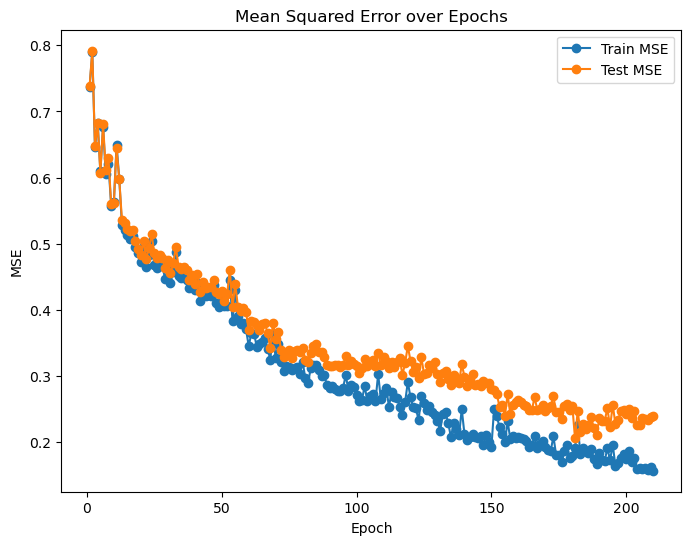

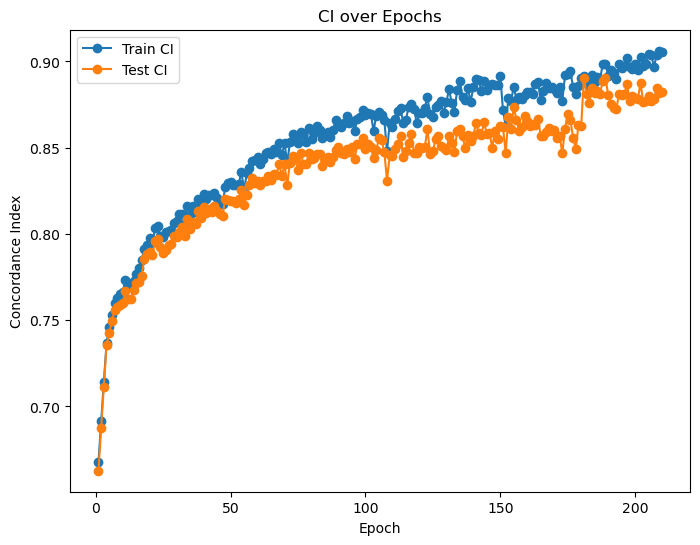

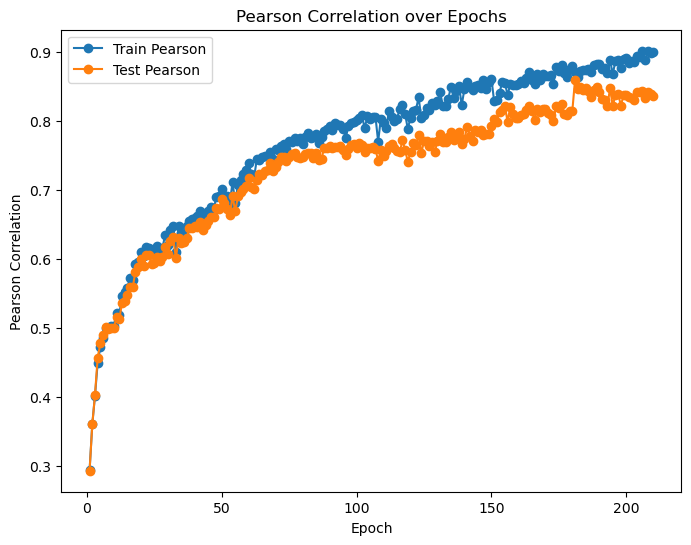

In [8]:
plot_metrics('')

In [ ]:

# import os
# import torch

# def train_and_evaluate(sample_dir, num_epochs=10, test_size=0.2, lr=0.001):
#     """
#     Trains the GNN model, evaluates on train & test each epoch, saves metrics + checkpoints.
#     """
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"Running on {device}.")

#     # Gather samples
#     sample_files = [f for f in os.listdir(sample_dir) if f.endswith('.pt')]
#     assert len(sample_files) > 0, "No .pt files found in sample_dir!"

#     # Split
#     train_files, test_files = train_test_split(sample_files, test_size=test_size, random_state=42)

#     # Make checkpoint dir
#     training_model_dir = os.path.join(os.getcwd(), 'TrainingModelMul')
#     os.makedirs(training_model_dir, exist_ok=True)
#     print(f"Checkpoints will be saved to: {training_model_dir}")

#     metrics_path = os.path.join(training_model_dir, "training_metrics.pt")

#     # Load existing metrics if available (Ensures metrics continue from previous runs)
#     if os.path.exists(metrics_path):
#         saved_metrics = torch.load(metrics_path)
#         train_metrics = saved_metrics['train_metrics']
#         test_metrics = saved_metrics['test_metrics']
#         print("Loaded previous training metrics!")
#     else:
#         train_metrics = {'epoch': [], 'mse': [], 'ci': [], 'pearson': []}
#         test_metrics = {'epoch': [], 'mse': [], 'ci': [], 'pearson': []}
#         print("Starting fresh metrics tracking.")

#     # Infer input dims from one sample
#     sample0 = load_sample(os.path.join(sample_dir, train_files[0]))
#     mol_data0, pro_data0 = sample0[0], sample0[1]
#     num_features_mol = mol_data0.x.size(1)
#     num_features_pro = pro_data0.x.size(1)

#     # Initialize model
#     model = GNNNet(num_features_mol=num_features_mol,
#                    num_features_pro=num_features_pro).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     loss_fn = MSELoss()

#     # Possibly resume from checkpoint
#     start_epoch = 1
#     existing_checkpoints = [
#         f for f in os.listdir(training_model_dir)
#         if f.endswith('.pt') and f.startswith('model_epoch')
#     ]
#     last_ckpt_path = None  # Track previous checkpoint for deletion

#     if existing_checkpoints:
#         latest_ckpt = max(existing_checkpoints, key=lambda x: int(x.split('_epoch')[1].split('.pt')[0]))
#         ckpt_path = os.path.join(training_model_dir, latest_ckpt)
#         print(f"Loading checkpoint from {ckpt_path}")
#         ckpt = torch.load(ckpt_path, map_location=device)
#         model.load_state_dict(ckpt['model_state_dict'])
#         optimizer.load_state_dict(ckpt['optimizer_state_dict'])
#         loaded_epoch = ckpt['epoch']
#         start_epoch = loaded_epoch + 1
#         last_ckpt_path = ckpt_path  # Store last checkpoint path for deletion
#         print(f"Resuming from epoch {start_epoch}")
#     else:
#         print("No existing checkpoint found; starting fresh.")

#     @torch.no_grad()
#     def evaluate(files):
#         model.eval()
#         all_preds = []
#         all_targets = []
#         batch_eval_size = 200
#         for batch_samples in batch_loader(files, sample_dir, batch_eval_size):
#             mol_list, pro_list, tgt_list = [], [], []
#             for (md, pd, t) in batch_samples:
#                 mol_list.append(md)
#                 pro_list.append(pd)
#                 tgt_list.append(t)

#             mol_batch = Batch.from_data_list(mol_list).to(device)
#             pro_batch = Batch.from_data_list(pro_list).to(device)
#             t_tensor = torch.tensor(tgt_list, dtype=torch.float32, device=device)

#             out = model(mol_batch, pro_batch).view(-1)
#             all_preds.append(out)
#             all_targets.append(t_tensor)

#         all_preds = torch.cat(all_preds, dim=0)
#         all_targets = torch.cat(all_targets, dim=0)

#         mse_val = mse_torch(all_preds, all_targets)
#         ci_val = ci_vectorized(all_preds, all_targets)
#         pearson_val = pearson_torch(all_preds, all_targets)
#         return mse_val, ci_val, pearson_val

#     # Training loop
#     batch_size = 500
#     for epoch in tqdm(range(start_epoch, num_epochs + 1), desc="Training", unit="epoch"):
#         model.train()
#         running_loss = 0.0

#         for batch_samples in batch_loader(train_files, sample_dir, batch_size):
#             mol_list, pro_list, tgt_list = [], [], []
#             for (md, pd, t) in batch_samples:
#                 mol_list.append(md)
#                 pro_list.append(pd)
#                 tgt_list.append(t)

#             mol_batch = Batch.from_data_list(mol_list).to(device)
#             pro_batch = Batch.from_data_list(pro_list).to(device)
#             t_tensor = torch.tensor(tgt_list, dtype=torch.float32, device=device).view(-1)

#             optimizer.zero_grad()
#             out = model(mol_batch, pro_batch).view(-1)
#             loss = loss_fn(out, t_tensor)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * len(batch_samples)

#         avg_loss = running_loss / len(train_files)
#         tqdm.write(f"[Epoch {epoch}/{num_epochs}] Training Loss: {avg_loss:.4f}")

#         # Evaluate on train & test
#         train_mse, train_ci, train_pearson = evaluate(train_files)
#         test_mse, test_ci, test_pearson = evaluate(test_files)

#         train_metrics['epoch'].append(epoch)
#         train_metrics['mse'].append(train_mse)
#         train_metrics['ci'].append(train_ci)
#         train_metrics['pearson'].append(train_pearson)

#         test_metrics['epoch'].append(epoch)
#         test_metrics['mse'].append(test_mse)
#         test_metrics['ci'].append(test_ci)
#         test_metrics['pearson'].append(test_pearson)

#         tqdm.write(f"  Train => MSE={train_mse:.4f}, CI={train_ci:.4f}, Pearson={train_pearson:.4f}")
#         tqdm.write(f"  Test  => MSE={test_mse:.4f}, CI={test_ci:.4f}, Pearson={test_pearson:.4f}")

#         # Save new checkpoint
#         ckpt_name = f"model_epoch{epoch}.pt"
#         ckpt_path = os.path.join(training_model_dir, ckpt_name)
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#         }, ckpt_path)
#         tqdm.write(f"Checkpoint saved at epoch {epoch}")

#         # Delete the previous checkpoint after saving the new one
#         if last_ckpt_path and os.path.exists(last_ckpt_path):
#             os.remove(last_ckpt_path)
#             tqdm.write(f"Deleted previous checkpoint: {last_ckpt_path}")

#         # Update last checkpoint path
#         last_ckpt_path = ckpt_path

#         # Save/Update the metrics after each epoch
#         torch.save({
#             'train_metrics': train_metrics,
#             'test_metrics': test_metrics
#         }, metrics_path)

#     # Final evaluations
#     final_train_mse, final_train_ci, final_train_pearson = evaluate(train_files)
#     final_test_mse, final_test_ci, final_test_pearson = evaluate(test_files)
#     print(f"\nFinal Train => MSE={final_train_mse:.4f}, CI={final_train_ci:.4f}, Pearson={final_train_pearson:.4f}")
#     print(f"Final Test  => MSE={final_test_mse:.4f}, CI={final_test_ci:.4f}, Pearson={final_test_pearson:.4f}")

#     # Save final metrics
#     torch.save({
#         'train_metrics': train_metrics,
#         'test_metrics': test_metrics
#     }, metrics_path)
#     print(f"Metrics saved to {metrics_path}")

#     return train_metrics, test_metrics


# ##############################################################################
# #               5. OPTIONAL: PLOT THE SAVED METRICS
# ##############################################################################

# def plot_metrics(checkpoint_dir='TrainingModelMul'):
#     """
#     Load training_metrics.pt from the checkpoint_dir and plot MSE, CI, Pearson over epochs.
#     """
#     metrics_path = os.path.join(checkpoint_dir, "training_metrics.pt")
#     if not os.path.exists(metrics_path):
#         print(f"No metrics file found at {metrics_path}!")
#         return

#     saved_data = torch.load(metrics_path)
#     train_metrics = saved_data['train_metrics']
#     test_metrics = saved_data['test_metrics']
#     epochs = train_metrics['epoch']

#     # Plot MSE
#     plt.figure(figsize=(8, 6))
#     plt.plot(epochs, train_metrics['mse'], 'o-', label='Train MSE')
#     plt.plot(epochs, test_metrics['mse'], 'o-', label='Test MSE')
#     plt.xlabel('Epoch')
#     plt.ylabel('MSE')
#     plt.title('Mean Squared Error over Epochs')
#     plt.legend()
#     plt.savefig(os.path.join(checkpoint_dir, "MSE_plot.png"))  
#     plt.show()

#     # Plot CI
#     plt.figure(figsize=(8, 6))
#     plt.plot(epochs, train_metrics['ci'], 'o-', label='Train CI')
#     plt.plot(epochs, test_metrics['ci'], 'o-', label='Test CI')
#     plt.xlabel('Epoch')
#     plt.ylabel('Concordance Index')
#     plt.title('CI over Epochs')
#     plt.savefig(os.path.join(checkpoint_dir, "CI_plot.png"))  
#     plt.legend()
#     plt.show()

#     # Plot Pearson
#     plt.figure(figsize=(8, 6))
#     plt.plot(epochs, train_metrics['pearson'], 'o-', label='Train Pearson')
#     plt.plot(epochs, test_metrics['pearson'], 'o-', label='Test Pearson')
#     plt.xlabel('Epoch')
#     plt.ylabel('Pearson Correlation')
#     plt.title('Pearson Correlation over Epochs')
#     plt.legend()
#     plt.savefig(os.path.join(checkpoint_dir, "PEARSON_plot.png"))  
#     plt.show()

# ##############################################################################
# #                                 MAIN
# ##############################################################################

# if __name__ == "__main__":
#     # Adjust the paths/parameters as needed
#     SAMPLE_DIR = "prepared_samples"   # Directory with your .pt samples
#     NUM_EPOCHS = 250
#     TEST_SPLIT = 0.2
#     LR = 0.001

#     # 1) Train and evaluate
#     train_metrics, test_metrics = train_and_evaluate(
#         sample_dir=SAMPLE_DIR,
#         num_epochs=NUM_EPOCHS,
#         test_size=TEST_SPLIT,
#         lr=LR
#     )

#     # 2) Plot the metrics
#     plot_metrics('TrainingModelMul')